In [132]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [133]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel
import itertools

In [134]:
load_file_path=os.path.join('/content/drive/My Drive/2023 InterpretingNN/code/experiment and result stage2/Baseline fashion', 'Copy of Baseline fashion 1*1.csv')
print(load_file_path)

save_folder='/content/drive/My Drive/2023 InterpretingNN/code/experiment and result stage2/Baseline fashion/processed data'

/content/drive/My Drive/2023 InterpretingNN/code/experiment and result stage2/Baseline fashion/Copy of Baseline fashion 1*1.csv


In [135]:
# Load the CSV file into a dataframe
dataframe = pd.read_csv(load_file_path)

add flops col

In [136]:
def preprocess_dataframe(df, flops_dict):
    # Step 1: Modify column names and remove specific columns
    #df.rename(columns={'conv1x1_3x3.1': 'conv1x1_3x3', 'conv1x1_5x5.1': 'conv1x1_5x5'}, inplace=True)
    #df.drop(columns=['conv1x1_3x3.0', 'conv1x1_5x5.0'], inplace=True)

    # Step 2: Add FLOPS columns
    for col, value in flops_dict.items():
        df[col] = value

    return df

# Example usage:
flops_dict = {"branch1.0FLOPS": 0.012544, "branch2.0FLOPS": 0.012544, "branch3.0FLOPS": 0.012544, "totalFLOPS": 9.674}
df = preprocess_dataframe(dataframe, flops_dict)

normalize layer feature attribution in this stack

In [138]:
def normalize_feature_attribution_final(df):
    """
    Final modification of the normalization of feature attributions for each layer.

    Parameters:
    df (DataFrame): The dataframe containing the feature attributions.

    Returns:
    DataFrame: A modified dataframe with normalized feature attributions for each layer.
    """
    # Columns to be normalized
    layers = ['branch1.0','branch2.0','branch3.0']

    # New sum calculation using specific layers
    df['sum_feature_attr'] = df[layers].sum(axis=1)

    # Normalize each layer by dividing by the new sum of feature attributions
    for layer in layers:
        df[f'norm_{layer}'] = df[layer] / df['sum_feature_attr']

    df.drop(['sum_feature_attr','branch1.0','branch2.0','branch3.0'], axis=1, inplace=True)

    return df

# Example usage of the final modified function
normalized_final_df = normalize_feature_attribution_final(df.copy())

get average and normalzied variance for each combination of hyperparameter

In [139]:
def calculate_normalized_variance(df, method, flops_dict):
    """
    Modified combined function to calculate the average and normalized variance of each layer's feature attribution
    for a given method, including both average and variance in one dataframe, along with average accuracy after each epoch.
    This version also includes FLOPS information.

    Parameters:
    df (DataFrame): The dataframe containing the data.
    method (str): The method to filter the data ('deeplift' or 'integrated_gradients').
    flops_dict (dict): Dictionary containing FLOPS values for different layers.

    Returns:
    DataFrame: A dataframe with the average and normalized variance for each layer combined, and average accuracy after each epoch, including FLOPS info.
    """
    # Filter the dataframe based on the method
    filtered_df = df[df['method'] == method]

    # Columns for which to calculate average and normalized variance, excluding certain layers
    layers = ['norm_branch1.0','norm_branch2.0','norm_branch3.0']
    accuracy_columns = ['train accuracy epoch0', 'test accuracy epoch0']

    # Group by hyperparameters and calculate mean and variance for feature attributions and accuracy
    grouped = filtered_df.groupby(['initial_lr', 'optimizer', 'criterion', 'train_data_used', 'train_set_shuffle', 'train_batch_size'])
    avg_norm = grouped[layers].mean()
    var_norm = grouped[layers].var()
    avg_acc = grouped[accuracy_columns].mean()

    # Calculate normalized variance (variance/mean)
    norm_var = var_norm / avg_norm

    # Combine average and normalized variance into one dataframe
    combined_df = avg_norm.copy()
    for layer in layers:
        combined_df[f'norm_var_{layer}'] = norm_var[layer]

    # Calculate the average normalized variance across the selected layers
    norm_var_layers = [f'norm_var_{layer}' for layer in layers]
    combined_df['avg_normalized_variance'] = combined_df[norm_var_layers].mean(axis=1)

    # Adding average accuracy columns
    for acc_col in accuracy_columns:
        combined_df[acc_col] = avg_acc[acc_col]

    # Add FLOPS information
    for flops_key, flops_value in flops_dict.items():
        combined_df[flops_key] = flops_value

    return combined_df

# Example usage
combined_avg_norm_var_acc_integrated_gradients = calculate_normalized_variance(normalized_final_df, 'integrated_gradients', flops_dict)

In [140]:
combined_avg_norm_var_acc_integrated_gradients.to_csv(save_folder+"/Baseline fashion 1*1 ig.csv")
combined_avg_norm_var_acc_integrated_gradients=pd.read_csv(save_folder+"/Baseline fashion 1*1 ig.csv")

In [141]:
def filter_by_accuracy(df, threshold=70.0):
    """
    Function to filter out rows where the average accuracy across epoch 3 (both train and test) is lower than a specified threshold.

    Parameters:
    df (DataFrame): The dataframe containing the data.
    threshold (float): The threshold for average accuracy in epoch 3.

    Returns:
    DataFrame: A filtered dataframe with rows having average epoch 3 accuracy higher than the threshold.
    """
    # Columns representing epoch 3 accuracy
    epoch_3_accuracy_cols = ['test accuracy epoch0']

    # Calculate the average accuracy for epoch 3
    df['final_test_accuracy'] = df[epoch_3_accuracy_cols].mean(axis=1)

    # Filter the dataframe based on the threshold
    filtered_df = df[df['final_test_accuracy'] >= threshold]

    return filtered_df

# Apply the function to the dataframes for 'deeplift' and 'integrated_gradients'
filtered_integrated_gradients = filter_by_accuracy(combined_avg_norm_var_acc_integrated_gradients)

# Display the first few rows of the filtered dataframes
filtered_integrated_gradients

,initial_lr,optimizer,criterion,train_data_used,train_set_shuffle,train_batch_size,norm_branch1.0,norm_branch2.0,norm_branch3.0,norm_var_norm_branch1.0,norm_var_norm_branch2.0,norm_var_norm_branch3.0,avg_normalized_variance,train accuracy epoch0,test accuracy epoch0,branch1.0FLOPS,branch2.0FLOPS,branch3.0FLOPS,totalFLOPS,final_test_accuracy
0,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,16,0.311387,0.378290,0.310323,0.020796,0.006904,0.012722,0.013474,81.379778,84.087333,0.012544,0.012544,0.012544,9.674,84.087333
1,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,32,0.310279,0.380457,0.309264,0.020799,0.006661,0.012830,0.013430,80.970111,84.351333,0.012544,0.012544,0.012544,9.674,84.351333
2,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,64,0.308787,0.383211,0.308002,0.019397,0.006023,0.013214,0.012878,80.573222,81.108000,0.012544,0.012544,0.012544,9.674,81.108000
3,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,16,0.309355,0.380524,0.310121,0.021363,0.007942,0.012078,0.013794,81.355778,83.679333,0.012544,0.012544,0.012544,9.674,83.679333
4,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,32,0.309220,0.383847,0.306933,0.020669,0.006036,0.013463,0.013389,81.049889,83.475333,0.012544,0.012544,0.012544,9.674,83.475333
5,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,0.307031,0.384931,0.308038,0.019699,0.006599,0.012996,0.013098,80.418889,83.297333,0.012544,0.012544,0.012544,9.674,83.297333
6,0.0007,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,16,0.316601,0.370312,0.313087,0.021939,0.009370,0.013929,0.015079,81.293556,84.430667,0.012544,0.012544,0.012544,9.674,84.430667
7,0.0007,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,32,0.310803,0.374235,0.314961,0.018767,0.007475,0.011716,0.012653,80.915556,84.287333,0.012544,0.012544,0.012544,9.674,84.287333
8,0.0007,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,64,0.306896,0.379688,0.313417,0.020619,0.007355,0.011776,0.013250,80.345000,81.912667,0.012544,0.012544,0.012544,9.674,81.912667
9,0.0007,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,16,0.317186,0.363752,0.319062,0.022164,0.010475,0.013243,0.015294,81.368778,83.902667,0.012544,0.012544,0.012544,9.674,83.902667


# Graph

In [142]:
def plot_variance_for_multiple_hyperparam_values(df, hyperparam, variables):
    """
    Plots bar graphs of the average variance of each layer and the overall average variance
    for multiple values of a given hyperparameter.

    Parameters:
    df (DataFrame): The dataframe containing the data.
    hyperparam (str): The hyperparameter to vary.
    variables (list): A list of values for the hyperparameter to compare.

    Returns:
    None: The function plots graphs directly.
    """
    # Check if the hyperparameter exists in the dataframe
    if hyperparam not in df.columns:
        print(f"Column '{hyperparam}' not found in dataframe.")
        return

    # Extracting variance columns
    variance_columns = [col for col in df.columns if 'norm_var' in col]
    variance_columns.append('avg_normalized_variance')

    # Preparing data for plotting
    plot_data = pd.DataFrame()
    for var in variables:
        subset = df[df[hyperparam] == var]
        avg_variances = subset[variance_columns].mean().to_frame().T
        avg_variances['hyperparam_value'] = var
        plot_data = pd.concat([plot_data, avg_variances])

    plot_data.set_index('hyperparam_value', inplace=True)

    # Plotting average variance for each layer and overall average
    plot_data.plot(kind='bar')
    plt.title(f'Average Variance for Different {hyperparam} Values')
    plt.ylabel('Average Variance')
    plt.xlabel(hyperparam)
    plt.xticks(rotation=45)
    plt.show()


In [143]:
filtered_integrated_gradients.to_csv(save_folder+"/Baseline fashion 1*1 ig ave var.csv")

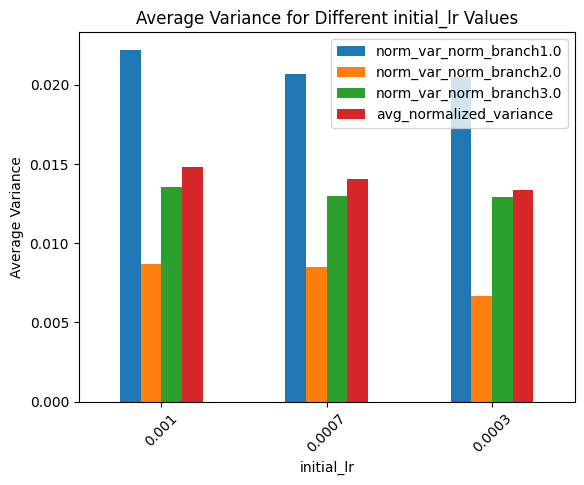

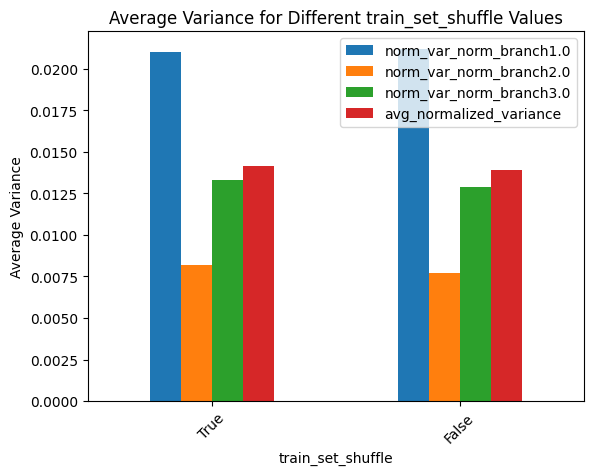

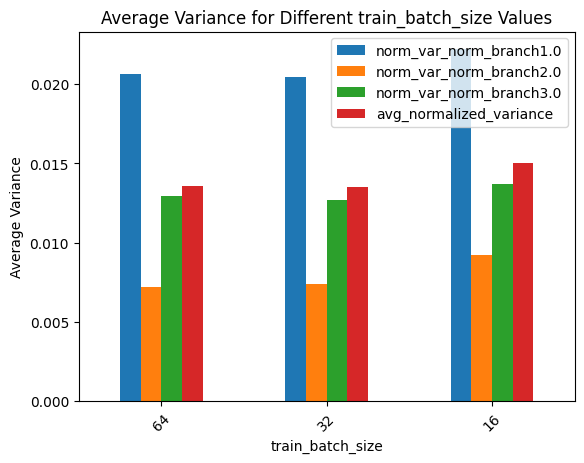

In [144]:
hyperparams_choice_list = {
    'initial_lr': [0.001, 0.0007, 0.0003],
    'train_set_shuffle': [True,False],
    'train_batch_size': [64, 32, 16]
}

for hyperparam, variables in hyperparams_choice_list.items():
    plot_variance_for_multiple_hyperparam_values(filtered_integrated_gradients, hyperparam, variables)

# T test

In [145]:
def perform_t_test(df, target_column, condition_column, choice1, choice2):
    # Splitting the data into two groups based on the condition
    group1 = df[df[condition_column] == choice1][target_column]
    group2 = df[df[condition_column] == choice2][target_column]

    # Performing the independent t-test
    t_statistic, p_value = ttest_ind(group1, group2)

    return t_statistic, p_value

initial_lr

In [146]:
result = perform_t_test(filtered_integrated_gradients, 'avg_normalized_variance', 'initial_lr', 0.001, 0.0007)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: 1.194621804462977 P-value: 0.2597995765742481


In [147]:
result = perform_t_test(filtered_integrated_gradients, 'avg_normalized_variance', 'initial_lr', 0.0007, 0.0003)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: 1.561088587728937 P-value: 0.1495649742762262


In [148]:
result = perform_t_test(filtered_integrated_gradients, 'avg_normalized_variance', 'initial_lr', 0.001, 0.0003)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: 2.837859874520123 P-value: 0.017612910228910383


train_set_shuffle

In [149]:
result = perform_t_test(filtered_integrated_gradients, 'avg_normalized_variance', 'train_set_shuffle', True, False)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: 0.4577062078067847 P-value: 0.6533177736735012


train_batch_size

In [150]:
result = perform_t_test(filtered_integrated_gradients, 'avg_normalized_variance', 'train_batch_size', 64, 32)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: 0.21623350238392564 P-value: 0.8331529035086827


In [151]:
result = perform_t_test(filtered_integrated_gradients, 'avg_normalized_variance', 'train_batch_size', 64, 16)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: -2.583962027024404 P-value: 0.027230586960578597


In [152]:
result = perform_t_test(filtered_integrated_gradients, 'avg_normalized_variance', 'train_batch_size', 32, 16)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: -2.811450619208681 P-value: 0.018428977602340964


# Paired T test

In [153]:
def one_sided_paired_ttest(data_set1, data_set2):
    """
    Perform a one-sided paired t-test to determine if the first data set is statistically larger than the second.

    Parameters:
    data_set1 (array-like): The first set of data.
    data_set2 (array-like): The second set of data.

    Returns:
    tuple: A tuple containing the t-statistic and the one-sided p-value.
    """
    t_statistic, p_value = ttest_rel(data_set1, data_set2)

    # Adjust p-value for one-sided test
    if t_statistic > 0:
        p_value_one_sided = p_value / 2
    else:
        p_value_one_sided = 1 - (p_value / 2)

    return t_statistic, p_value_one_sided

# Example usage:
# t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
# print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)


In [154]:
def find_rows_with_fixed_conditions(df, conditions):
    # Filter the DataFrame based on the conditions
    filtered_df = df
    for column, value in conditions.items():
        filtered_df = filtered_df[filtered_df[column] == value]

    return filtered_df

In [155]:
def generate_hyperparameter_combinations(hyperparams):
    """
    Generate a sequence of hyperparameter combinations.

    :param hyperparams: A dictionary where keys are the names of hyperparameters,
                        and values are lists of possible choices for each hyperparameter.
    :return: A list of dictionaries, each representing a unique combination of hyperparameters.
    """
    # Extract the hyperparameter names and their corresponding choices
    keys, values = zip(*hyperparams.items())

    # Generate all possible combinations of hyperparameter values
    all_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

    return all_combinations

In [156]:
def get_all_pairs(df, hyperparams_choice_list, target_column, condition_column, choice1, choice2):
    hyperparams_choice_list_compressed = {key: value for key, value in hyperparams_choice_list.items() if key != condition_column}
    all_combinations = generate_hyperparameter_combinations(hyperparams_choice_list_compressed)
    choice1_target_values=[]
    choice2_target_values=[]
    for conditions in all_combinations:
      x = find_rows_with_fixed_conditions(df, conditions)
      try:
        choice1_value = float(x[x[condition_column] == choice1][target_column])
        choice2_value = float(x[x[condition_column] == choice2][target_column])
        print(choice1_value, choice2_value)
      except:
        continue
      choice1_target_values.append(choice1_value)
      choice2_target_values.append(choice2_value)
    return choice1_target_values, choice2_target_values

initial_lr

In [157]:
data_pairs=get_all_pairs(filtered_integrated_gradients, hyperparams_choice_list, 'avg_normalized_variance', 'initial_lr', 0.001, 0.0007)
t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)

0.0140104053134894 0.0138279737947188
0.0136048890086049 0.0140620361460385
0.0165145175103728 0.0152939229513642
0.0145342902102649 0.0132498911240127
0.0140279245526741 0.0126525478874637
0.0161340603508624 0.0150791218269088
T-statistic: 2.5580647919685413 One-sided P-value: 0.02538291552371166


In [158]:
data_pairs=get_all_pairs(filtered_integrated_gradients, hyperparams_choice_list, 'avg_normalized_variance', 'initial_lr', 0.0007, 0.0003)
t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)

0.0138279737947188 0.0130978906381888
0.0140620361460385 0.0133893394520301
0.0152939229513642 0.0137943382891393
0.0132498911240127 0.0128781033047768
0.0126525478874637 0.0134298631956643
0.0150791218269088 0.013474331808252
T-statistic: 1.9339892382450325 One-sided P-value: 0.05546088863521647


In [159]:
data_pairs=get_all_pairs(filtered_integrated_gradients, hyperparams_choice_list, 'avg_normalized_variance', 'initial_lr', 0.001, 0.0003)
t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)

0.0140104053134894 0.0130978906381888
0.0136048890086049 0.0133893394520301
0.0165145175103728 0.0137943382891393
0.0145342902102649 0.0128781033047768
0.0140279245526741 0.0134298631956643
0.0161340603508624 0.013474331808252
T-statistic: 3.362961178659571 One-sided P-value: 0.010021507928797004


train_set_shuffle

In [160]:
data_pairs=get_all_pairs(filtered_integrated_gradients, hyperparams_choice_list, 'avg_normalized_variance', 'train_set_shuffle', True, False)
t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)

0.0140104053134894 0.0145342902102649
0.0136048890086049 0.0140279245526741
0.0165145175103728 0.0161340603508624
0.0138279737947188 0.0132498911240127
0.0140620361460385 0.0126525478874637
0.0152939229513642 0.0150791218269088
0.0130978906381888 0.0128781033047768
0.0133893394520301 0.0134298631956643
0.0137943382891393 0.013474331808252
T-statistic: 1.2458329483421584 One-sided P-value: 0.1240367054181964


train_batch_size

In [161]:
data_pairs=get_all_pairs(filtered_integrated_gradients, hyperparams_choice_list, 'avg_normalized_variance', 'train_batch_size', 32, 64)
t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)

0.0136048890086049 0.0140104053134894
0.0140279245526741 0.0145342902102649
0.0140620361460385 0.0138279737947188
0.0126525478874637 0.0132498911240127
0.0133893394520301 0.0130978906381888
0.0134298631956643 0.0128781033047768
T-statistic: -0.3613590666754232 One-sided P-value: 0.6337007485958123


In [162]:
data_pairs=get_all_pairs(filtered_integrated_gradients, hyperparams_choice_list, 'avg_normalized_variance', 'train_batch_size', 16, 32)
t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)

0.0165145175103728 0.0136048890086049
0.0161340603508624 0.0140279245526741
0.0152939229513642 0.0140620361460385
0.0150791218269088 0.0126525478874637
0.0137943382891393 0.0133893394520301
0.013474331808252 0.0134298631956643
T-statistic: 3.241981069432717 One-sided P-value: 0.011449405638737125


In [163]:
data_pairs=get_all_pairs(filtered_integrated_gradients, hyperparams_choice_list, 'avg_normalized_variance', 'train_batch_size', 16, 64)
t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)

0.0165145175103728 0.0140104053134894
0.0161340603508624 0.0145342902102649
0.0152939229513642 0.0138279737947188
0.0150791218269088 0.0132498911240127
0.0137943382891393 0.0130978906381888
0.013474331808252 0.0128781033047768
T-statistic: 4.945124275222081 One-sided P-value: 0.002151500636721096


#layer feature attribution rank frequency comparison

In [164]:
normalized_df = normalized_final_df[normalized_final_df['method'] == 'integrated_gradients']
normalized_df_highacc = filter_by_accuracy(normalized_df)
normalized_df_highacc

<ipython-input-141-4ef74943cc56>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['final_test_accuracy'] = df[epoch_3_accuracy_cols].mean(axis=1)


,initial_lr,optimizer,criterion,train_data_used,train_set_shuffle,train_batch_size,train accuracy epoch0,test accuracy epoch0,method,run,branch1.0FLOPS,branch2.0FLOPS,branch3.0FLOPS,totalFLOPS,norm_branch1.0,norm_branch2.0,norm_branch3.0,final_test_accuracy
1,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,80.078333,81.05,integrated_gradients,0,0.012544,0.012544,0.012544,9.674,0.445303,0.321322,0.233374,81.05
3,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,80.560000,84.11,integrated_gradients,1,0.012544,0.012544,0.012544,9.674,0.246580,0.325146,0.428273,84.11
5,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,80.718333,82.90,integrated_gradients,2,0.012544,0.012544,0.012544,9.674,0.200007,0.400736,0.399257,82.90
7,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,80.418333,83.12,integrated_gradients,3,0.012544,0.012544,0.012544,9.674,0.270452,0.440407,0.289141,83.12
9,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,79.420000,84.25,integrated_gradients,4,0.012544,0.012544,0.012544,9.674,0.357180,0.340718,0.302101,84.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
531,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,16,81.798333,84.81,integrated_gradients,10,0.012544,0.012544,0.012544,9.674,0.236867,0.437753,0.325380,84.81
533,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,16,81.348333,84.08,integrated_gradients,11,0.012544,0.012544,0.012544,9.674,0.337896,0.393692,0.268413,84.08
535,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,16,80.940000,83.79,integrated_gradients,12,0.012544,0.012544,0.012544,9.674,0.248398,0.416748,0.334854,83.79
537,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,16,81.290000,84.51,integrated_gradients,13,0.012544,0.012544,0.012544,9.674,0.316052,0.382326,0.301621,84.51


In [165]:
# Select the columns of interest
cols_of_interest = ['norm_branch1.0', 'norm_branch2.0', 'norm_branch3.0']
data_subset = normalized_df_highacc[cols_of_interest]

# Function to get rank as a string
def get_rank_string(row):
    return ''.join(row.rank().astype(int).astype(str))

# Apply the function to each row
data_subset['rank_combination'] = data_subset.apply(get_rank_string, axis=1)

# Count the frequency of each rank combination
rank_combination_counts = data_subset['rank_combination'].value_counts()

rank_combination_counts

<ipython-input-165-85bc6b39743e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['rank_combination'] = data_subset.apply(get_rank_string, axis=1)


231    72
321    68
132    64
123    51
213    13
312     2
Name: rank_combination, dtype: int64